# GMVAE
This framework is modified from scVI with a Gaussian mixture latent variable variantion.

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import scanpy as sc
import anndata
from torch.distributions import Normal, kl_divergence as kl
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import normalized_mutual_info_score as NMI
from sklearn.metrics import adjusted_rand_score as ARI

In [3]:
from sklearn.cluster import KMeans
import sklearn

# Read data

In [4]:
class AnnDataset(torch.utils.data.Dataset):
    def __init__(self, X_ann):
        # TODO
        # 1. Initialize file paths or a list of file names.
        self.X = X_ann.obsm['X']
        self.local_mean = X_ann.obs['local_mean']
        self.local_var = X_ann.obs['local_var']
#        self.batch_index = X_ann.obs['batch_index']
#        self.fake_labels = X_ann.obs['fake_labels']
    def __getitem__(self, index):
        # TODO
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        sample_x = self.X[index]
        sample_local_mean = self.local_mean[index]
        sample_local_var = self.local_var[index]
#        sample_batch_index = self.batch_index[index]
#        sample_fake_labels = self.fake_labels[index]

        sample = {'x': sample_x, 'local_mean':sample_local_mean,'local_var':sample_local_var}
#                 'batch_index':sample_batch_index,'fake_labels':sample_fake_labels}
        return sample

    def __len__(self):
        # the total size of your dataset.
        return len(self.X)



In [5]:
raw_adata = sc.read_h5ad("../data/cortex_scAnnData.h5ad")

In [6]:
raw_adata.obsm

AxisArrays with keys: X, X_pca, X_tsne, X_umap

In [7]:
raw_adata.obsm['X']

array([[8.220e+02, 0.000e+00, 0.000e+00, ..., 7.000e+00, 1.000e+01,
        6.000e+00],
       [8.690e+02, 0.000e+00, 0.000e+00, ..., 9.000e+00, 0.000e+00,
        1.100e+01],
       [1.237e+03, 1.000e+00, 0.000e+00, ..., 1.000e+01, 5.000e+00,
        1.800e+01],
       ...,
       [3.760e+02, 0.000e+00, 0.000e+00, ..., 1.000e+00, 1.000e+00,
        0.000e+00],
       [3.030e+02, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.420e+02, 2.800e+01, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        2.000e+00]], dtype=float32)

In [8]:
local_mean = np.log(raw_adata.obsm['X'].sum(axis=1)).mean()

local_var = np.log(raw_adata.obsm['X'].sum(axis=1)).var()

raw_adata.obs['local_mean'] = local_mean

raw_adata.obs['local_var'] = local_var

#raw_adata.obs['clusters'] = raw_adata.obs['Group']
BATCH_SIZE = 128

ann_dataset = AnnDataset(raw_adata)
train_loader = torch.utils.data.DataLoader(dataset=ann_dataset,
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True,drop_last = True)

# Loss

In [9]:
def log_zinb_positive(x, mu, theta, pi, eps=1e-8):

    # theta is the dispersion rate. If .ndimension() == 1, it is shared for all cells (regardless of batch or labels)
    if theta.ndimension() == 1:
        theta = theta.view(
            1, theta.size(0)
        )  # In this case, we reshape theta for broadcasting

    softplus_pi = F.softplus(-pi)
    log_theta_eps = torch.log(theta + eps)
    log_theta_mu_eps = torch.log(theta + mu + eps)
    pi_theta_log = -pi + theta * (log_theta_eps - log_theta_mu_eps)

    case_zero = F.softplus(pi_theta_log) - softplus_pi
    mul_case_zero = torch.mul((x < eps).type(torch.float32), case_zero)

    case_non_zero = (
        -softplus_pi
        + pi_theta_log
        + x * (torch.log(mu + eps) - log_theta_mu_eps)
        + torch.lgamma(x + theta)
        - torch.lgamma(theta)
        - torch.lgamma(x + 1)
    )
    mul_case_non_zero = torch.mul((x > eps).type(torch.float32), case_non_zero)

    res = mul_case_zero + mul_case_non_zero

    return res

# Model

In [10]:
def reparameterize_gaussian(mu, var):
    return Normal(mu, var.sqrt()).rsample()

class Encoder(nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(n_in, n_hidden),
                                     nn.BatchNorm1d(n_hidden, momentum=0.01, eps=0.001),
                                     nn.ReLU())
        self.mean_encoder = nn.Linear(n_hidden, n_out)
        self.var_encoder = nn.Linear(n_hidden, n_out)
        
    def forward(self, x: torch.Tensor):
        
        q = self.encoder(x)
        
        q_m = self.mean_encoder(q)
        q_v = torch.exp(self.var_encoder(q)) + 1e-4
        latent = reparameterize_gaussian(q_m, q_v)
        
        return q_m, q_v, latent
    

# GMVAE

In [11]:
def reparameterize_gaussian(mu, var):
    return Normal(mu, var.sqrt()).rsample()

class qy_encoder(nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(n_in, n_hidden),
                                     nn.BatchNorm1d(n_hidden, momentum=0.01, eps=0.001),
                                     nn.ReLU(),
                                    nn.Linear(n_hidden, n_out),
                                    nn.Softmax())
    def forward(self, x):
        y = self.encoder(x)
        return y

class qz_encoder(nn.Module):
    def __init__(self, n_in,k, n_hidden, n_out):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(n_in + k, n_hidden),
                                     nn.BatchNorm1d(n_hidden, momentum=0.01, eps=0.001),
                                     nn.ReLU())
        self.mean_encoder = nn.Linear(n_hidden, n_out)
        self.var_encoder = nn.Linear(n_hidden, n_out)
        
    def forward(self, x: torch.Tensor, y):
        y = y.expand(x.size(0),y.size(0))
        q = self.encoder(torch.cat([x,y],dim=1))
        
        q_m = self.mean_encoder(q)
        q_v = torch.exp(self.var_encoder(q)) + 1e-4
        latent = reparameterize_gaussian(q_m, q_v)
        
        return q_m, q_v, latent

In [12]:
class qx_decoder(nn.Module):
    def __init__(self, n_in, k, n_hidden, n_out):
        super().__init__()
        self.zm_trans = nn.Sequential(nn.Linear(k, n_in))
        self.zv_trans = nn.Sequential(nn.Linear(k,n_in), nn.Softplus())
        
        self.px_decoder = nn.Sequential(nn.Linear(n_in, n_hidden),
                                    nn.BatchNorm1d(n_hidden, momentum=0.01, eps=0.001),
                                    nn.ReLU())
        # mean gamma
        self.px_scale_decoder = nn.Sequential(
            nn.Linear(n_hidden, n_out), nn.Softmax(dim=-1)
        )        

        # dropout
        self.px_dropout_decoder = nn.Linear(n_hidden, n_out)

        # dispersion: here we only deal with gene-cell dispersion case
        self.px_r_decoder = nn.Linear(n_hidden, n_out)


        
    def forward(self, z: torch.Tensor, library: torch.Tensor, y:torch.Tensor):
        
        zm = self.zm_trans(y)
        zv = self.zv_trans(y)
        
        px = self.px_decoder(z)
        px_scale = self.px_scale_decoder(px)
        px_rate = torch.exp(library) * px_scale  
        # torch.clamp( , max=12)

        px_dropout = self.px_dropout_decoder(px)
        
        px_r = self.px_r_decoder(px) 

        return px_scale, px_r, px_rate, px_dropout, zm, zv

In [13]:
def log_normal(x, mu, var, eps = 0.0, dim = 0):
    if eps > 0.0:
        var = var + eps
    return torch.sum(-1/2 * (torch.log(2 * torch.tensor(np.pi)) + torch.log(var) + (x - mu)**2 / var), dim = 1)

In [14]:
class GMVAE(nn.Module):
    def __init__(self,n_input, n_hidden = 128, n_latent_z = 32, k = 7):
        super().__init__()
        
        self.k = k
        
        self.y_encoder = qy_encoder(n_input, n_hidden, k)
        self.z_encoder_list =[None] * k
        for i in range(k):
            self.z_encoder_list[i] = qz_encoder(n_input, k, n_hidden, n_latent_z)
        
        self.l_encoder = Encoder(n_input, n_hidden, 1)
        
        self.decoder_z = qx_decoder(n_latent_z, k, n_hidden, n_input)
        
    #    self.decoder_pi = Decoder(n_latent_pi, n_hidden, n_input)
        self.px_r = torch.nn.Parameter(torch.randn(n_input))
        
    def forward(self, x:torch.Tensor, local_l_mean, local_l_var):
        x_ = x
        x_ = torch.log(x_ + 1)
        
        k = self.k
        
        ql_m, ql_v, library = self.l_encoder(x_)
    
        kl_divergence_l = kl(Normal(ql_m, torch.sqrt(ql_v)),Normal(local_l_mean, torch.sqrt(local_l_var))).sum(dim=1)


        y = self.y_encoder(x_)
        
        y_ = torch.Tensor(np.eye(self.k))
        
        z, zm, zv, zm_prior, zv_prior, px_scale, px_r, px_rate, px_dropout = [[None] * k for i in range(9)]
        
        losses = [None] * k
        reconstruct_losses = [None] * k
        log_normal_losses = [None] * k
        
        px_r = torch.exp(self.px_r)
        for i in range(k):
            zm[i], zv[i], z[i] = self.z_encoder_list[i](x, y_[i])
            
            _, _, px_rate[i], px_dropout[i], zm_prior[i], zv_prior[i] = self.decoder_z(z[i], library, y_[i])
        
            reconstruct_losses[i] = -log_zinb_positive(x, px_rate[i], px_r, px_dropout[i]).sum(dim = 1)
            
            log_normal_losses[i] = log_normal(z[i],zm[i],zv[i]) - log_normal(z[i],zm_prior[i],zv_prior[i])#kl(Normal(zm[i],torch.sqrt(zv[i])), Normal(zm_prior[i], torch.sqrt(zv_prior[i])))
            
            losses[i] = reconstruct_losses[i] + log_normal_losses[i]
        
        loss = 0.
        entropy = 0
        for i in range(k):
            loss += y[:,i] * losses[i]
            entropy += -y[:,i] * torch.log(y[:,i])
        
        entropy = torch.mean(entropy)
        loss = torch.mean(loss)
        return -entropy, loss
    
    def get_latent_cluster(self, x):
        with torch.no_grad():
            x_ = x
            x_ = torch.log(1 + x_)
        
            y = self.y_encoder(x_)
            
        return y

# Train

In [15]:
gmvae = GMVAE(n_input = raw_adata.obsm['X'].shape[1],n_latent_z=2,n_hidden=128,k=7)
learning_rate=1e-3
weight_decay = 1e-6
eps = 0.01
epoch = -1
params = gmvae.parameters()
optimizer = torch.optim.Adam(
            params, lr=learning_rate, eps=eps, weight_decay= weight_decay
        )   

In [16]:
def train(model, train_loader,optimizer, val_loader = None, start_epoch = 0,num_epochs=30, seed=1,
          save_path = "train_with_tsne/"):

    for epoch in range(start_epoch,num_epochs):
        model.train()
        print(optimizer.param_groups[0]['lr'])

        for i, sample in enumerate(train_loader):
            x = sample['x']
            local_l_mean = sample['local_mean']
            local_l_var = sample['local_var']
            
            neg_entropy, final = model(x, local_l_mean, local_l_var)

            loss = neg_entropy + final
            #loss = loss.mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
     #       scheduler.step(loss)


            if i % 5 == 0:
                print("Epoch[{}/{}], Step [{}/{}],  Loss: {:.4f}, Neg Entropy: {:.4f}, Recon Loss: {:.4f}".format(
                                        epoch, num_epochs, i, len(train_loader), loss.item(), neg_entropy.item(), final.item()))





In [17]:
train(gmvae,train_loader,optimizer, num_epochs = 50, start_epoch = epoch + 1)

0.001


/home/grad/jiangyuanli/miniconda/envs/py37/lib/python3.7/site-packages/torch-1.2.0-py3.7-linux-x86_64.egg/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch[0/50], Step [0/23],  Loss: 36273.7695, Neg Entropy: -1.8863, Recon Loss: 36275.6562
Epoch[0/50], Step [5/23],  Loss: 27720.9297, Neg Entropy: -1.7131, Recon Loss: 27722.6426
Epoch[0/50], Step [10/23],  Loss: 24259.9277, Neg Entropy: -1.5546, Recon Loss: 24261.4824
Epoch[0/50], Step [15/23],  Loss: 21425.0938, Neg Entropy: -1.4509, Recon Loss: 21426.5449
Epoch[0/50], Step [20/23],  Loss: 21122.6445, Neg Entropy: -1.4217, Recon Loss: 21124.0664
0.001
Epoch[1/50], Step [0/23],  Loss: 20079.2793, Neg Entropy: -1.4212, Recon Loss: 20080.7012
Epoch[1/50], Step [5/23],  Loss: 20732.9180, Neg Entropy: -1.4166, Recon Loss: 20734.3340
Epoch[1/50], Step [10/23],  Loss: 16258.2598, Neg Entropy: -1.3697, Recon Loss: 16259.6299
Epoch[1/50], Step [15/23],  Loss: 17347.4688, Neg Entropy: -1.3605, Recon Loss: 17348.8301
Epoch[1/50], Step [20/23],  Loss: 14799.8379, Neg Entropy: -1.2910, Recon Loss: 14801.1289
0.001
Epoch[2/50], Step [0/23],  Loss: 14900.5996, Neg Entropy: -1.2982, Recon Loss: 149

Epoch[18/50], Step [5/23],  Loss: 1965.3199, Neg Entropy: -1.0490, Recon Loss: 1966.3689
Epoch[18/50], Step [10/23],  Loss: 1591.3845, Neg Entropy: -0.9368, Recon Loss: 1592.3213
Epoch[18/50], Step [15/23],  Loss: 1713.2795, Neg Entropy: -1.0492, Recon Loss: 1714.3287
Epoch[18/50], Step [20/23],  Loss: 1826.4091, Neg Entropy: -1.0531, Recon Loss: 1827.4622
0.001
Epoch[19/50], Step [0/23],  Loss: 1668.2284, Neg Entropy: -0.9982, Recon Loss: 1669.2266
Epoch[19/50], Step [5/23],  Loss: 1735.8693, Neg Entropy: -1.0865, Recon Loss: 1736.9557
Epoch[19/50], Step [10/23],  Loss: 1613.7498, Neg Entropy: -0.9343, Recon Loss: 1614.6841
Epoch[19/50], Step [15/23],  Loss: 1848.6293, Neg Entropy: -1.0541, Recon Loss: 1849.6835
Epoch[19/50], Step [20/23],  Loss: 1716.4993, Neg Entropy: -0.9730, Recon Loss: 1717.4723
0.001
Epoch[20/50], Step [0/23],  Loss: 1669.2588, Neg Entropy: -0.9736, Recon Loss: 1670.2323
Epoch[20/50], Step [5/23],  Loss: 1694.0125, Neg Entropy: -1.0710, Recon Loss: 1695.0834
Epo

Epoch[36/50], Step [10/23],  Loss: 1585.3214, Neg Entropy: -0.7795, Recon Loss: 1586.1008
Epoch[36/50], Step [15/23],  Loss: 1596.8245, Neg Entropy: -0.7361, Recon Loss: 1597.5605
Epoch[36/50], Step [20/23],  Loss: 1577.9585, Neg Entropy: -0.8235, Recon Loss: 1578.7820
0.001
Epoch[37/50], Step [0/23],  Loss: 1563.1665, Neg Entropy: -0.7758, Recon Loss: 1563.9423
Epoch[37/50], Step [5/23],  Loss: 1624.0646, Neg Entropy: -0.7842, Recon Loss: 1624.8488
Epoch[37/50], Step [10/23],  Loss: 1641.4772, Neg Entropy: -0.8048, Recon Loss: 1642.2820
Epoch[37/50], Step [15/23],  Loss: 1583.0308, Neg Entropy: -0.7699, Recon Loss: 1583.8007
Epoch[37/50], Step [20/23],  Loss: 1552.6801, Neg Entropy: -0.6904, Recon Loss: 1553.3705
0.001
Epoch[38/50], Step [0/23],  Loss: 1569.9846, Neg Entropy: -0.7730, Recon Loss: 1570.7576
Epoch[38/50], Step [5/23],  Loss: 1575.5100, Neg Entropy: -0.6778, Recon Loss: 1576.1879
Epoch[38/50], Step [10/23],  Loss: 1608.6571, Neg Entropy: -0.7495, Recon Loss: 1609.4066
Ep

In [18]:
gmvae.eval()
latent = gmvae.get_latent_cluster(torch.Tensor(raw_adata.obsm['X']))

In [19]:
y = latent.detach().numpy()

In [20]:
l = np.argmax(y,axis=1)

In [21]:
ARI(l,raw_adata.obs['clusters'])

0.15410758192453997

In [22]:
NMI(l,raw_adata.obs['clusters'])

0.2941203942476933

In [23]:
post_adata = anndata.AnnData(X=raw_adata.X)
post_adata.obsm["X_scVI"] = latent.detach().numpy()
post_adata.obs['cell_type'] = raw_adata.obs['clusters']

In [24]:
sc.pp.neighbors(post_adata, use_rep="X_scVI", n_neighbors=15)
sc.tl.umap(post_adata, min_dist=0.1)

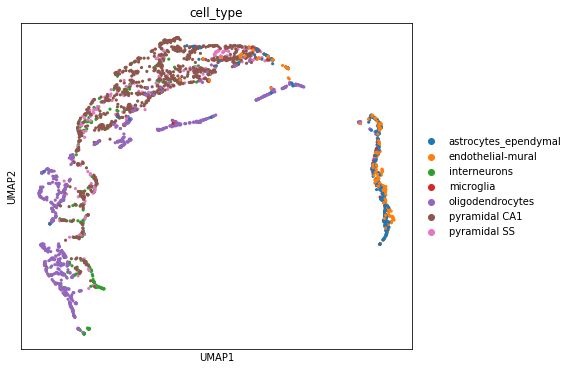

In [25]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(post_adata, color=["cell_type"], ax=ax)#, show=show_plot)

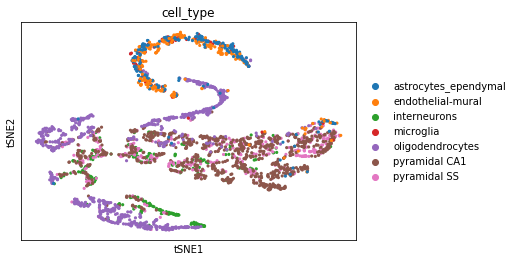

In [26]:
sc.tl.tsne(post_adata, use_rep="X_scVI")
sc.pl.tsne(post_adata,color=['cell_type'])#,save="_cortex_scvi.png")

In [27]:
from sklearn.cluster import KMeans

out = KMeans(n_clusters=7).fit(latent)

out.labels_

sklearn.metrics.normalized_mutual_info_score(out.labels_,raw_adata.obs['clusters'])



0.31344585329644314

In [28]:
sklearn.metrics.adjusted_rand_score(out.labels_,raw_adata.obs['clusters'])




0.17845843915598023